This notebook covers **chapter 05: Resampling Methods** of the book [ISL](https://www.statlearning.com/).

**NOTE:**
Most of these ideas are not directly applicable to unsupervised learning. In unsupervised learning, we do not have labels, and therefore, there are other approaches to measure the validity of clusters.

The idea is to resample again and again from a data set to obtain additional information about the fitted model!

**Resampling Methods**
* **Cross-Validation**
    * Validation set
    * Leave-One-Out Cross-Validation (LOOCV)
    * k-Fold Cross-Validtion (poplular!)
* **bootstrap**
    * h

## import libraries

In [97]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

## data

In [4]:
# Auto_2.csv data
# problem: predicting mpg using horsepower

data = pd.read_csv("./datasets/Auto_2.csv", index_col=0)
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
2,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
3,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
4,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
5,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [10]:
features_name = ['horsepower']
target_name = ['mpg']

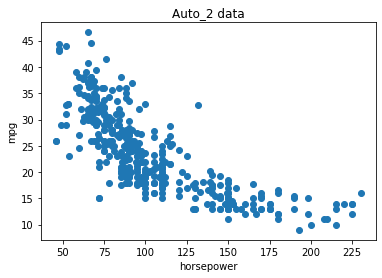

In [17]:
# visualization

X = data[features_name].to_numpy(dtype=np.float64)
y = data[target_name].to_numpy(dtype=np.float64)

plt.scatter(X, y)
plt.title("Auto_2 data")
plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.show()

It  seems there is a quadratic (or maybe with higher degree) relationship between the feature `horsepower` and `mpg`. Let us see if we can find it out.

In [26]:
X = data[features_name].to_numpy(dtype=np.float64)
y = data[target_name].to_numpy(dtype=np.float64).ravel()

print('shape of X: ', X.shape)
print('shape of y: ', y.shape)

shape of X:  (392, 1)
shape of y:  (392,)


## Cross Validation

The idea is simple: creating a `train set` and `validation set` from a data set to examine the performance of fitted model on validation set. But, there are different ways on how to get those train / test sets, and how to perform evaluation.

### I. Validation Set

In validation set, the data set is partitioned into two parts, train set and validation set, e.g. 70% train, and 30% validation test. (Note that this is `train_test_split` in scikit-learn!). Then, we fit the model on train set, and then evaluate its performance on test set.

In [40]:
MSE = []
n_itr = 10
max_degree = 10

print('i', end='-->')
for i in range(n_itr):
    print(i, end='--')
    MSE_i = []
    seed = i 
    for j in range(1, max_degree + 1):
        X_poly = PolynomialFeatures(degree=j).fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.25, random_state=seed)
        
        model = LinearRegression().fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_test_pred)
        MSE_i.append(mse)
    
    MSE.append(MSE_i)

print('Done!')

i-->0--1--2--3--4--5--6--7--8--9--Done!


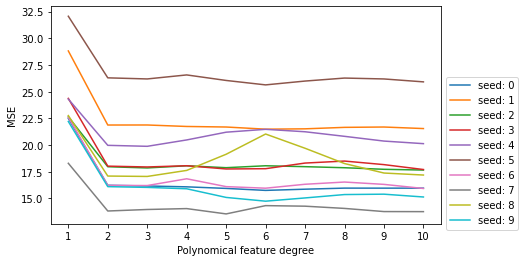

In [72]:
# Reproducing Fig.5.2 (right)
# Note that the splitting of data and different size of train set can result in different figures.

plt.figure(figsize=(7, 4))
for i in range(n_itr):
    plt.plot(MSE[i], label=f'seed: {i}')

xticks = list(range(0, max_degree))
xlabels = list(range(1, max_degree + 1))
plt.xticks(ticks=xticks, labels=xlabels)

plt.xlabel('Polynomical feature degree')
plt.ylabel('MSE')
plt.legend(bbox_to_anchor=(1.01, 0, 0.2, 0.7))
plt.show()

Let us take a look degree 6. According to seed 8, MSE is high; howeber, MSE is lowest in seed 9! In other ways, different randomized seperation of train/validation sets can results in different outcomes! 

**Advantage:** 
* Easy!

**Disadvantage:** 
* The splitting part is happening once, and therefore, there is a high chance that our model does not capture the underlying structure of data. In other words, if we repeat this process several times, there is a high chance that we get different MSE curves (for different DoF). 

* In this approach, we are losing a chunk of data and therefore, the fitted model may not be fitted well. So, it may performs worse compared to when it is trained using the whole data. So, it can overestimate the test error!

### II. LOOCV

For a data set with m observations, this approach creates m datasets such that the `i-th` data set contains all observations except the `i-th` one! The idea is to fit a model on `m-1` observation but hold out one and then evaluate the fitted model on that held-out observation. By doing this process for each of those m observations, we will get m values for  MSE, and thus: $MSE_{tot} = avg(MSEs)$

**Advantage:**
* It has far less bias compared to `Validation Set` approach. It is repeated `m` times, and each time we fit the model with help of almost all observations (we are just excluding one observation each time). Therefore, it does not overestimate the test error.
* Since this method performs on each of those m observations, the result will remain the same.

**Disadvantage:**
* Computing time: For large data sets and / or comlex models that require high computing time, this method is heavily time consuming. 

In [88]:
MSE = []
max_degree = 10

for deg in range(1, max_degree + 1):
    sum_mse = 0
    loocv = LeaveOneOut()
    X_poly = PolynomialFeatures(degree=deg).fit_transform(X)
    
    for train_IDX, test_idx in loocv.split(X_poly):
        regressor = LinearRegression().fit(X_poly[train_IDX], y[train_IDX])
        y_test_pred = regressor.predict(X_poly[test_idx])
    
        sum_mse += mean_squared_error(y[test_idx], y_test_pred)
    
    avg_sme = sum_mse / X_poly.shape[0]
    MSE.append(avg_sme)

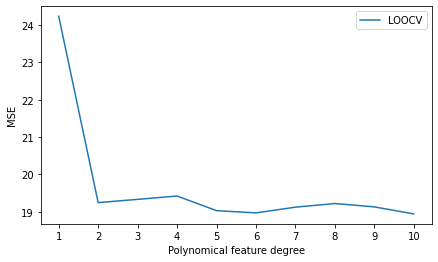

In [91]:
plt.figure(figsize=(7, 4))
plt.plot(MSE, label='LOOCV')

xticks = list(range(0, max_degree))
xlabels = list(range(1, max_degree + 1))
plt.xticks(ticks=xticks, labels=xlabels)

plt.xlabel('Polynomical feature degree')
plt.ylabel('MSE')
plt.legend()
plt.show()

### III. K-Fold Cross-Validation

This can be a trade-off betweem `Validation Set` and `LOOCV`. In this approach, we divide a data set into k (usually equally-sized) groups. Then, we hold out one group as a validation set, and fit the model on the remaining data. We do this for `k` iteration, and in each iteration we hold out one of those `k` groups. The MSE is the average of MSE on test set.

In [100]:
cv = 10
n_itr = 10

MSE = []
for i in range(n_itr):
    MSE_i = []
    for deg in range(1, 11):
        X_poly = PolynomialFeatures(degree=deg).fit_transform(X)
        
        mse = 0
        kf = KFold(n_splits=cv, shuffle=True, random_state=i)
        for train_index, test_index in kf.split(X_poly):
            regressor = LinearRegression().fit(X_poly[train_index], y[train_index])
            y_test_pred = regressor.predict(X_poly[test_index])
            mse += mean_squared_error(y[test_index], y_test_pred)

        mse_avg = mse / cv
        MSE_i.append(mse_avg)
    
    MSE.append(MSE_i)

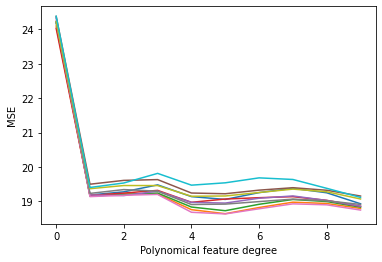

In [102]:
for i in range(n_itr):
    plt.plot(MSE[i])
    
plt.xlabel('Polynomical feature degree')
plt.ylabel('MSE')
plt.show()

Now we can see the curves are close to each other. This shows that our decision based on a particular partitioning of data set (into k-folds) can be trusted.

`K-Fold` is also good for  bias-variance trade-off. There is no doubt that LOOCV has less bias as it uses almost all data for training the model. However, since LOOCV is using almost all information in each iteration, it can result in a high-variance model. So, it cannot understand the underlying structure of  data. 
<br>
k-fold, on the other hand, is good for creating a trade-off between bias and variance. Since it is not using all the data, it is better in avoiding variance as it tries to capture the overal behavior of data rather than creating a model that is fitted well to almost all seen data.

**NOTE:**
<br>
In classification, we have the indicator `I`, which is 1 for correct prediction, and 0 for incorrect one. So, the cv concepts can be easily extended to classification topic as well.


**off-topic note:**
<br>
what is quadratic logistic regression? It is a logistic regression on feature X_poly, the outcome of Polynomical feature engineering.


**off-topic note:**
<br>
In KNN, higher value of `k`, means less flexibility (and thus less variance) but higher bias. (Think about highest value for k... what is that? It is all neighbors, so the out come of KNN will remain the same from one test point to another. This shows that we have lowest flexibility and highest bias!. The variance is also 0 as it does not change!!)

## Bootstrapping

In nutshell, it is sampling n items from n observations, with replacement! So, one set of samples might have more than one of the same observation. We can then calculate the standard deviation of the variable of our interest using the `B` sets of samples created through bootstrapping.

The idea is simple and thus, we avoid providing further details here.